In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [2]:
(x_train_image,y_train_label),(x_test_image,y_test_label) = tf.keras.datasets.cifar10.load_data()
x_train_normalize = x_train_image.astype('float32')/255
x_test_normalize = x_test_image.astype('float32')/255
y_train_OneHot = tf.keras.utils.to_categorical(y_train_label)
y_test_OneHot = tf.keras.utils.to_categorical(y_test_label)

In [30]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D,Dropout
from tensorflow.keras.layers import Activation, Add, Concatenate, Conv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import MaxPool2D,AveragePooling2D, BatchNormalization, Lambda, DepthwiseConv2D
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K




def channel_split(x, name=''):
    # 输入进来的通道数
    in_channles = x.shape.as_list()[-1]
    ip = in_channles // 2
    # 对通道数进行分割
    c_hat = Lambda(lambda z: z[:, :, :, 0:ip], name='%s/sp%d_slice' % (name, 0))(x)
    c = Lambda(lambda z: z[:, :, :, ip:], name='%s/sp%d_slice' % (name, 1))(x)
    return c_hat, c

def channel_shuffle(x):
    height, width, channels = x.shape.as_list()[1:]
    channels_per_split = channels // 2
    # 通道交换
    x = K.reshape(x, [-1, height, width, 2, channels_per_split])
    x = K.permute_dimensions(x, (0,1,2,4,3))
    x = K.reshape(x, [-1, height, width, channels])
    return x


def shuffle_unit(inputs, out_channels, bottleneck_ratio, strides=2, stage=1, block=1):
    bn_axis = -1

    prefix = 'stage{}/block{}'.format(stage, block)

    # [116, 232, 464]
    bottleneck_channels = int(out_channels * bottleneck_ratio/2)
    if strides < 2:
        c_hat, c = channel_split(inputs, '{}/spl'.format(prefix))
        inputs = c

    # [116, 232, 464]
    x = Conv2D(bottleneck_channels, kernel_size=(1,1), strides=1, padding='same', name='{}/1x1conv_1'.format(prefix))(inputs)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_1'.format(prefix))(x)
    x = Activation('relu', name='{}/relu_1x1conv_1'.format(prefix))(x)

    # 深度可分离卷积
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', name='{}/3x3dwconv'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv'.format(prefix))(x)
    
    # [116, 232, 464]
    x = Conv2D(bottleneck_channels, kernel_size=1,strides=1,padding='same', name='{}/1x1conv_2'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_2'.format(prefix))(x)
    x = Activation('relu', name='{}/relu_1x1conv_2'.format(prefix))(x)

    # 当strides等于2的时候，残差边需要添加卷积
    if strides < 2:
        ret = Concatenate(axis=bn_axis, name='{}/concat_1'.format(prefix))([x, c_hat])
    else:
        s2 = DepthwiseConv2D(kernel_size=3, strides=2, padding='same', name='{}/3x3dwconv_2'.format(prefix))(inputs)
        s2 = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv_2'.format(prefix))(s2)

        s2 = Conv2D(bottleneck_channels, kernel_size=1,strides=1,padding='same', name='{}/1x1_conv_3'.format(prefix))(s2)
        s2 = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_3'.format(prefix))(s2)
        s2 = Activation('relu', name='{}/relu_1x1conv_3'.format(prefix))(s2)
        ret = Concatenate(axis=bn_axis, name='{}/concat_2'.format(prefix))([x, s2])

    ret = Lambda(channel_shuffle, name='{}/channel_shuffle'.format(prefix))(ret)

    return ret


def block(x, channel_map, bottleneck_ratio, repeat=1, stage=1):
    x = shuffle_unit(x, out_channels=channel_map[stage-1],
                      strides=2,bottleneck_ratio=bottleneck_ratio,stage=stage,block=1)

    for i in range(1, repeat+1):
        x = shuffle_unit(x, out_channels=channel_map[stage-1],strides=1,
                          bottleneck_ratio=bottleneck_ratio,stage=stage, block=(1+i))

    return x

def ShuffleNetV2(input_tensor=None,
                 pooling='max',
                 input_shape=(224,224,3),
                 num_shuffle_units=[3,7,3],
                 scale_factor=1,
                 bottleneck_ratio=1,
                 #classes=1000
                 classes=10):
    name = 'ShuffleNetV2_{}_{}_{}'.format(scale_factor, bottleneck_ratio, "".join([str(x) for x in num_shuffle_units]))

    out_dim_stage_two = {0.5:48, 1:116, 1.5:176, 2:244}

    out_channels_in_stage = np.array([1,1,2,4])
    out_channels_in_stage *= out_dim_stage_two[scale_factor]  #  calculate output channels for each stage
    out_channels_in_stage[0] = 24  # first stage has always 24 output channels
    out_channels_in_stage = out_channels_in_stage.astype(int)

    img_input = Input(shape=input_shape)

    x = Conv2D(filters=out_channels_in_stage[0], kernel_size=(3, 3), padding='same', use_bias=False, strides=(2, 2),
               activation='relu', name='conv1')(img_input)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='maxpool1')(x)

    for stage in range(len(num_shuffle_units)):
        repeat = num_shuffle_units[stage]
        x = block(x, out_channels_in_stage,
                   repeat=repeat,
                   bottleneck_ratio=bottleneck_ratio,
                   stage=stage + 2)

    if scale_factor!=2:
        x = Conv2D(1024, kernel_size=1, padding='same', strides=1, name='1x1conv5_out', activation='relu')(x)
    else:
        x = Conv2D(2048, kernel_size=1, padding='same', strides=1, name='1x1conv5_out', activation='relu')(x)
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = Dense(1024,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128,activation='relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(classes, name='fc')(x)
    x = Activation('softmax', name='softmax')(x)

    inputs = img_input

    model = Model(inputs, x, name=name)

    return model

if __name__ == '__main__':
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    #model = ShuffleNetV2(input_shape=(224, 224, 3),scale_factor=1)
    model = ShuffleNetV2(input_shape=(32, 32, 3),scale_factor=1)
    model.summary()


Model: "ShuffleNetV2_1_1_373"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 24)   648         input_9[0][0]                    
__________________________________________________________________________________________________
maxpool1 (MaxPooling2D)         (None, 8, 8, 24)     0           conv1[0][0]                      
__________________________________________________________________________________________________
stage2/block1/1x1conv_1 (Conv2D (None, 8, 8, 58)     1450        maxpool1[0][0]                   
_______________________________________________________________________________

In [31]:

#model = keras.models.Model(input)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model_train = model.fit(x=x_train_normalize,y=y_train_OneHot,validation_split=0.2,epochs=30,batch_size=300,verbose=1)

Epoch 1/30
134/134 [==============================] - 4s 33ms/step - loss: 2.2907 - accuracy: 0.1225 - val_loss: 2.3031 - val_accuracy: 0.1016
Epoch 2/30
134/134 [==============================] - 3s 25ms/step - loss: 1.9656 - accuracy: 0.2353 - val_loss: 2.3123 - val_accuracy: 0.0977
Epoch 3/30
134/134 [==============================] - 3s 25ms/step - loss: 1.7378 - accuracy: 0.3350 - val_loss: 2.3739 - val_accuracy: 0.0977
Epoch 4/30
134/134 [==============================] - 3s 25ms/step - loss: 1.5935 - accuracy: 0.4077 - val_loss: 2.2921 - val_accuracy: 0.1322
Epoch 5/30
134/134 [==============================] - 3s 25ms/step - loss: 1.4601 - accuracy: 0.4695 - val_loss: 1.7543 - val_accuracy: 0.3774
Epoch 6/30
134/134 [==============================] - 3s 25ms/step - loss: 1.3646 - accuracy: 0.5132 - val_loss: 1.4289 - val_accuracy: 0.4767
Epoch 7/30
134/134 [==============================] - 3s 25ms/step - loss: 1.2826 - accuracy: 0.5475 - val_loss: 1.5975 - val_accuracy: 0.4681

In [32]:
def train_history(model_train,train,val):
    plt.plot(model_train.history[train])
    plt.plot(model_train.history[val])
    plt.title('Train History')
    plt.xlabel('epoch')
    plt.ylabel(train)
    plt.legend(['train','validation'],loc='upper left')

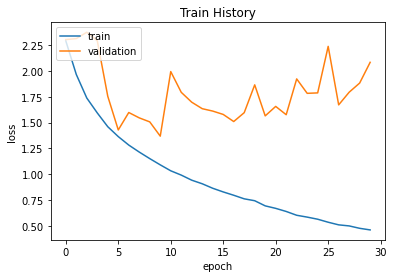

In [33]:
train_history(model_train,'loss','val_loss')

In [34]:
scores = model.evaluate(x_test_normalize,y_test_OneHot,verbose=2)

313/313 - 2s - loss: 2.0925 - accuracy: 0.5617


In [35]:
model.save('./shufflenet.h5', save_format="h5")